# Predicting Goals Probability

Expected goals (xG) provides a measure of how likely a goal is to be scored, based on the location of the shot and some other pertinent features. 

Later, the goal probability (xG) will be adjusted by modifiers (for example, discounting for not scoring on previous recent shots, shooting talent, game state, etc... and defensively, attributes such as shot proximity), to create a more comprehensive "goal contribution" metric, which will then be used in the Player Impact model.

Make separate models for predicting misses and goal using conditional probability (ignore blocks for now, but could use a constant prior for this later, and this could change by team in future versions). There are some useful feature categories that only are recorded for shots and goals, but not misses. Therefore, these can only be used if I create separate models for the two predictions. 

The expected goal distribution should be transformed based on the total number of goals in the training data. This could either be a simple scaling, or it could be a transformation of the distribution in a non-constant way. This could even be something learned with ML (i.e. a function applied to the features). For example, maybe shots near the goal should be left alone, while shots from far away should have their xG lowered. Since the limits of xG must be 0 and 1, a constant scaling factor does not work, therefore must use a function that follows the rules of a probability distribution.

The "other" category consists entirely of 4v3, 3v4 and empty net situations.

List of features
- time since last event
- distance to last event
- angle change from last event
- last event was shot
- last event was turnover
- off wing shot and one-timer
- goal differential
- shot was tipped/deflected
- shooter position (C, W, D)
- shooter height
- shooter weight
- shooter years played
- shooter age
- angle_change * (1 / time_since_last)
- delta_y * (1 / time_since_last)

Note: tips and deflections are only recorded for shots and goals, but not misses and blocks, so maybe this cannot be used

Note: remove blocks because the coordinates correspond to the location of the block, not the shot location

Features to include later:
- player types on ice
- player impact scores on ice
- player on ice shooting %
- defensive strength against
- offensive strength for

References
- https://www.ikigailabs.io/multivariate-time-series-forecasting-python/xgboost-predict-probability
- https://towardsdatascience.com/introduction-to-probabilistic-classification-a-machine-learning-perspective-b4776b469453


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import timedelta, datetime
from scipy.stats import kurtosis

# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from xgboost import XGBClassifier

from models.common_sql import create_db_connection, select_table, sql_select
# from models.common import binary_encoder
from models.common_plot import plot_calibration_curves
from models.common_torch import RegressionNN, CustomDataset, train_loop
from nhl_api.ref_common import game_time_to_sec


In [2]:
# Create the database connection
connection = create_db_connection('postgres', 'marshineer', 'localhost', '5432', 'password')

# https://stackoverflow.com/questions/3492904/mysql-select-all-columns-from-one-table-and-some-from-another-table
# https://www.sqlshack.com/sql-multiple-joins-for-beginners-with-examples/
# https://www.w3schools.com/sql/sql_join.asp
sql_query = """SELECT shots.*, players.birth_date, players.position2, players.rookie_season, players.full_name, games.datetime
               FROM shots
               LEFT JOIN players ON shots.shooter_id = players.player_id
               LEFT JOIN games ON shots.game_id = games.game_id"""

cols = ['game_id', 'shot_id', 'shooter_id', 'shot_type', 'shot_result',
        'period', 'period_time', 'home_team_id', 'away_team_id', 'home_score', 
        'away_score', 'x_coord', 'y_coord', 'net_distance', 'net_angle',
        'rebound_shot', 'last_event_type', 'time_since_last', 'last_x_coord',
        'last_y_coord', 'delta_y', 'angle_change', 'play_ends', 'puck_frozen',
        'goal', 'missed', 'blocked', 'empty_net', 'shooter_home', 'shooter_hand',
        'off_wing_shot', 'players_home', 'players_away', 'shooter_birth_date',
        'shooter_position', 'shooter_rookie_season', 'shooter_name', 'game_datetime']
shots_df = sql_select(connection, sql_query, cols=cols)
print(shots_df.columns.tolist())
print(shots_df.shooter_position.unique().tolist())
print(shots_df.last_event_type.unique().tolist())
print(shots_df.shot_result.unique().tolist())
print(shots_df.shot_type.unique().tolist())

# Sort the shots data
shots_df.sort_values(['game_id', 'shot_id'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Load the player data as a dictionary
players_df = select_table(connection, 'players')
# players_df = pd.read_csv('~/Hockey-Analytics/data/players.csv')
print(players_df.columns.tolist())
players_list = players_df.to_dict('records')
players = {player_x['player_id']: player_x for player_x in players_list}


['game_id', 'shot_id', 'shooter_id', 'shot_type', 'shot_result', 'period', 'period_time', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'x_coord', 'y_coord', 'net_distance', 'net_angle', 'rebound_shot', 'last_event_type', 'time_since_last', 'last_x_coord', 'last_y_coord', 'delta_y', 'angle_change', 'play_ends', 'puck_frozen', 'goal', 'missed', 'blocked', 'empty_net', 'shooter_home', 'shooter_hand', 'off_wing_shot', 'players_home', 'players_away', 'shooter_birth_date', 'shooter_position', 'shooter_rookie_season', 'shooter_name', 'game_datetime']
['D', 'F', 'G']
['GIVEAWAY', 'BLOCK', 'SHOT', 'HIT', 'TAKEAWAY', 'MISS', 'FACEOFF', 'GOAL', 'STOP', 'PENALTY']
['BLOCK', 'SHOT', 'MISS', 'GOAL']
[None, 'WRIST', 'SNAP', 'TIP', 'WRAP', 'SLAP', 'BACKHAND', 'DEFLECT', 'OTHER']
['player_id', 'full_name', 'birth_date', 'nationality', 'position', 'position2', 'rookie_season', 'shoots_catches', 'height_cm', 'weight_kg']


In [3]:
# Remove rows where the shift data contained errors
too_few_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) < 4) & shots_df.players_away.apply(lambda x: len(eval(x)) < 4)]
too_many_players = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) > 6) | shots_df.players_away.apply(lambda x: len(eval(x)) > 6)]
print(f'Number of shift error entries = {len(too_few_players) + len(too_many_players)}')
shots_df = shots_df[shots_df.players_home.apply(lambda x: len(eval(x)) >= 4) & shots_df.players_away.apply(lambda x: len(eval(x)) >= 4) & 
                    shots_df.players_home.apply(lambda x: len(eval(x)) <= 6) & shots_df.players_away.apply(lambda x: len(eval(x)) <= 6)]

# Remove rows with nan/null shot distance or angle
print(f'Number of shots with no distance info = {len(shots_df[shots_df.net_distance.isna() | shots_df.net_angle.isna()])}')
shots_df.dropna(subset=['net_distance', 'net_angle'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove rows with nan/null previous shot coordinates
print(f'Number of shots with no previous event location info = {len(shots_df[shots_df.angle_change.isna() | shots_df.delta_y.isna()])}')
shots_df.dropna(subset=['angle_change', 'delta_y'], inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove blocks
block_mask = shots_df.shot_result == 'BLOCK'
blocks_df = shots_df.loc[block_mask]
blocks_df.reset_index(drop=True, inplace=True)
block_list = blocks_df.to_dict('records')
thru_prob = 1 - (sum(block_mask) / len(shots_df))  # Assumes all shots have an equal chance of being blocked
print(f'Number of shots that are blocked = {len(block_mask)} ({100 * (1 - thru_prob):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[block_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# # Remove the empty net goals
# print(f'Number of goals on empty nets = {len(shots_df[shots_df.empty_net == True])} '
#       f'({100 * len(shots_df[shots_df.empty_net == True]) / len(shots_df[shots_df.shot_result == "GOAL"]):4.2f}% of all goals)')
# shots_df.drop(shots_df[shots_df.empty_net == True].index, inplace=True)
# shots_df.reset_index(drop=True, inplace=True)

# Remove all shots that come from outside the blueline, as these are never intended to go in
# Indirectly removes goalie shots (or it should at least)
long_mask = (((shots_df.period % 2 == 1) ^ (shots_df.shooter_home == True)) & (shots_df.x_coord < 25)) | \
    (~((shots_df.period % 2 == 1) ^ (shots_df.shooter_home == True)) & (shots_df.x_coord > -25))
print(f'Number of shots from outside the blueline = {sum(long_mask)} ({100 * sum(long_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[long_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove all shots from directly behind the net
# The net is 72" wide and 40" deep, so the angle from the center to the back corner is 138 degrees
# Any shots taken past this angle are essentially from directly behind the net and any goals from this area will be considered outliers
# Note: keeping some shots from behind the goal line, as bank shots often involve skill and/or intelligence
behind_net_mask = (shots_df.net_angle > 138) | (shots_df.net_angle < -138)
print(f'Number of shots from directly behind the net = {sum(behind_net_mask)} ({100 * sum(behind_net_mask) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df.loc[behind_net_mask].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove shots made by goalies
shots_df.drop(shots_df.loc[shots_df.shooter_position == 'G'].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Convert the shots to a list
shot_list = shots_df.to_dict('records')


Number of shift error entries = 735
Number of shots with no distance info = 28
Number of shots with no previous event location info = 799
Number of shots that are blocked = 1687046 (25.19% of all shots)
Number of shots from outside the blueline = 46462 (3.68% of all shots)
Number of shots from directly behind the net = 97 (0.01% of all shots)


In [4]:
shots_5v5 = []
for i, shot in enumerate(shot_list):
    home_players = eval(shot['players_home'])
    n_home = len(home_players)
    away_players = eval(shot['players_away'])
    n_away = len(away_players)
    home_shot = shot['shooter_home']

    # Check for empty net condition
    home_en = True
    away_en = True
    for player in home_players:
        if players[player]['position'] == 'G':
            home_en = False
    for player in away_players:
        if players[player]['position'] == 'G':
            away_en = False
    if home_en or away_en:
        continue

    # Check for other game states
    if n_home == 6 and n_away == 6:
        shots_5v5.append(shot)
shot_df_5v5 = pd.DataFrame(shots_5v5, columns=shots_df.columns.tolist())


In [5]:
# Add engineered features
new_shot_cols = ['team_lead', 'game_time', 'last_event_shot',
                 'last_event_turnover', 'player_age', 'player_seasons']
new_shot_data = []
for shot in shots_5v5:
    # Game time
    period = shot['period']
    period_time = shot['period_time']
    game_time = (period - 1) * 20 * 60 + game_time_to_sec(period_time)
    
    # Goal differential for the player's team
    if shot['shooter_home']:
        team_lead = shot['home_score'] - shot['away_score']
    else:
        team_lead = shot['away_score'] - shot['home_score']
        
    # Last event booleans
    last_event_shot = shot['last_event_type'] in ['SHOT', 'BLOCK', 'MISS']
    last_event_turnover = shot['last_event_type'] in ['GIVEAWAY', 'TAKEAWAY']
    
    # Player age and years played
    game_date = str(shot['game_datetime'])
    birthdate = shot['shooter_birth_date']
    d1 = datetime.strptime(birthdate, '%Y-%m-%d')
    d2 = datetime.strptime(game_date, '%Y-%m-%d %H:%M:%S')
    player_age = (d2 - d1).total_seconds() / (60 * 60 * 24)
    rookie_season = shot.get('shooter_rookie_season')
    player_seasons = (int(game_date[:4]) - rookie_season) if rookie_season is not None else 0
    
    # Append the new shot features
    new_shot_data.append([team_lead, game_time, last_event_shot,
                          last_event_turnover, player_age, player_seasons])
    
# Create a shot dataframe
new_shots_df = pd.DataFrame(new_shot_data, columns=new_shot_cols)
data_cols = shots_df.columns.tolist() + new_shot_cols
data_df = pd.concat([shot_df_5v5, new_shots_df], axis=1)


In [6]:
# Covert boolean columns to numerical
data_df.off_wing_shot = data_df.off_wing_shot.astype(int)
data_df.rebound_shot = data_df.rebound_shot.astype(int)
data_df.last_event_shot = data_df.last_event_shot.astype(int)
data_df.last_event_turnover = data_df.last_event_turnover.astype(int)
data_df.shooter_home = data_df.shooter_home.astype(int)
data_df.loc[data_df.shooter_hand == 'L', 'shooter_hand'] = 0
data_df.loc[data_df.shooter_hand == 'R', 'shooter_hand'] = 1
data_df.loc[data_df.shooter_position == 'D', 'shooter_position'] = 0
data_df.loc[data_df.shooter_position == 'F', 'shooter_position'] = 1
data_df.goal = data_df.goal.astype(int)
data_df.missed = data_df.missed.astype(int)


# Miss Prediction Probability Model

Create a model to predict the probability that a shot will miss the net
- Different models for different game states (PP: 5v4, 5v3; PK: combine 4v5 and 3v5; Even: 4v4, 5v5; empty net, ignore others)
- Use XGBoost, Random Forest, Naive Bayes, Logistic Regression, Neural Net
- Calibrate the model, if necessary (istonic regression or platt scaling)
- Perhaps use blocks as a prior to determine the probability of a shot becoming a goal from anywhere in the zone. Would change depending on the game state and the team (later). The prior should be a constant, or a simple function of features (eg. net_dist, net_angle). For example, since blocks probably occur closer to the net, a shot from in close is less likely to be blocked than those from farther away.


In [7]:
# For each game state, split the data into training and test sets
drop_cols = ['game_id', 'shot_id', 'shooter_id', 'shot_type', 'shot_result',
             'period', 'period_time', 'home_team_id', 'away_team_id',
             'home_score', 'away_score', 'x_coord', 'y_coord', 'last_event_type',
             'last_x_coord', 'last_y_coord', 'play_ends', 'puck_frozen',
             'goal', 'blocked', 'empty_net', 'players_home', 'players_away',
             'shooter_birth_date', 'shooter_rookie_season',
             'shooter_name', 'game_datetime', 'player_seasons']
new_cols = ['net_distance', 'net_angle', 'time_since_last', 'delta_y',
            'angle_change', 'team_lead', 'game_time', 'player_age',
            'rebound_shot', 'shooter_home', 'shooter_hand', 'shooter_position',
            'off_wing_shot', 'last_event_shot', 'last_event_turnover', 'missed']
# Convert the shot list to a dataframe
data_df.drop(columns=drop_cols, inplace=True)
data_df = data_df[new_cols]

# Calculate the trivial logloss for the game state
p_miss = len(data_df.loc[data_df.missed == True]) / len(data_df)
dumb_loss = -(p_miss * np.log(p_miss) + (1 - p_miss) * np.log(1 - p_miss))
print(f'{100 * p_miss:4.1f}% of 5-on-5 shots hit the net (trivial logloss = {dumb_loss:4.2f})')

# Split the data into stratified training and test sets
X_pd, y_pd = data_df.iloc[:, :-1].values, data_df.iloc[:, -1].values
tmp_split = train_test_split(X_pd, y_pd, test_size=0.3, random_state=66,
                             stratify=y_pd)
X_train, X_temp, y_train, y_temp = tmp_split
tmp_split = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
X_valid, X_test, y_valid, y_test = tmp_split

# Scale the data
x_scaler = MinMaxScaler()
X_train_norm = x_scaler.fit_transform(X_train[:, :8])
X_train[:, :8] = X_train_norm
X_valid_norm = x_scaler.transform(X_valid[:, :8])
X_valid[:, :8] = X_valid_norm
X_test_norm = x_scaler.transform(X_test[:, :8])
X_test[:, :8] = X_test_norm
    

28.4% of 5-on-5 shots hit the net (trivial logloss = 0.60)


In [8]:
# Logistic regression model
# https://medium.com/towards-data-science/assumptions-of-logistic-regression-clearly-explained-44d85a22b290
d_logr = {'name': 'Logistic Regression',
          'model': LogisticRegression(max_iter=500, penalty='l2', class_weight='balanced'),
          'params': {'solver': ['sag', 'saga'],
                     'C': [1, 10, 50, 100]}}
cv_split = StratifiedKFold(n_splits=10)

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
param_search = GridSearchCV(d_logr['model'], d_logr['params'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train, y_train)
d_logr['search_result'] = param_search
d_logr['model'] = param_search.best_estimator_
d_logr['train_loss'] = -param_search.best_score_

# Make predictions on the test set
d_logr['test_pred'] = d_logr['model'].predict_proba(X_test)[:, 1]
d_logr['test_loss'] = log_loss(y_test, d_logr['test_pred'])
pred_classes = np.round(d_logr['test_pred'], 0)
d_logr['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the logistic regression model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the Logit model: {d_logr['train_loss']:4.3f}")
print(f"Test logloss on the Logit model: {d_logr['test_loss']:4.3f}")
print(f"Test accuracy on the Logit model: {d_logr['test_acc']:4.2f}%")


Took 0:03:14.334349 to train the logistic regression model
Trivial logloss for this problem: 0.597
Training logloss on the Logit model: 0.687
Test logloss on the Logit model: 0.687
Test accuracy on the Logit model: 52.08%


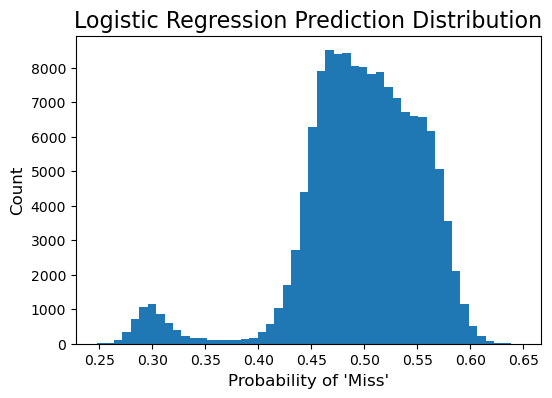

In [9]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_logr['test_pred'], bins=50)
ax.set_title('Logistic Regression Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [10]:
# Naive Bayes model
# https://scikit-learn.org/stable/modules/naive_bayes.html#
d_nbayes = {'name': 'Naive Bayes',
            'model': GaussianNB()}

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
d_nbayes['model'].fit(X_train, y_train)
d_nbayes['train_loss'] = log_loss(y_train, d_nbayes['model'].predict_proba(X_train)[:, 1])
d_nbayes['test_pred'] = d_nbayes['model'].predict_proba(X_test)[:, 1]
d_nbayes['test_loss'] = log_loss(y_test, d_nbayes['test_pred'])
pred_classes = np.round(d_nbayes['test_pred'], 0)
d_nbayes['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the naive bayes model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NB model: {d_nbayes['train_loss']:4.3f}")
print(f"Test logloss on the NB model: {d_nbayes['test_loss']:4.3f}")
print(f"Test accuracy on the NB model: {d_nbayes['test_acc']:4.2f}%")


Took 0:00:01.225497 to train the naive bayes model
Trivial logloss for this problem: 0.597
Training logloss on the NB model: 0.676
Test logloss on the NB model: 0.682
Test accuracy on the NB model: 67.98%


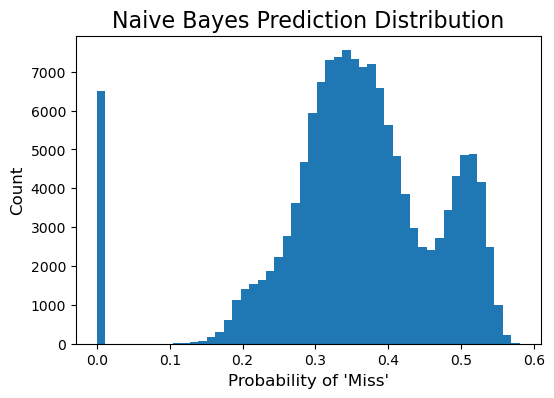

In [11]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nbayes['test_pred'], bins=50)
ax.set_title('Naive Bayes Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [12]:
# XGBoost model
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
d_xgb = {'name': 'XGBoost Classifier',
         'model': XGBClassifier(use_label_encoder=False, tree_method='hist'),
         'n_itr': 50,
         'params': {'n_estimators': [100, 200, 400],
                    'learning_rate': np.linspace(0., 0.9, 10),
                    'subsample': np.linspace(0.4, 1., 7),
                    'min_child_weight': [1, 5, 10, 20],
                    'max_leaves': [10, 20, 40, 80],
                    'max_depth': np.arange(2, 10),
                    'gamma': [1, 2, 4, 8]}}

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
# param_search = GridSearchCV(model['model'], model['params'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search = RandomizedSearchCV(d_xgb['model'], d_xgb['params'], n_iter=d_xgb['n_itr'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train, y_train)
d_xgb['search_result'] = param_search
d_xgb['model'] = param_search.best_estimator_
d_xgb['train_loss'] = -param_search.best_score_

# Make predictions on the test set
d_xgb['test_pred'] = d_xgb['model'].predict_proba(X_test)[:, 1]
d_xgb['test_loss'] = log_loss(y_test, d_xgb['test_pred'])
pred_classes = np.round(d_xgb['test_pred'], 0)
d_xgb['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the xgboost model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the XGB model: {d_xgb['train_loss']:4.3f}")
print(f"Test logloss on the XGB model: {d_xgb['test_loss']:4.3f}")
print(f"Test accuracy on the XGB model: {d_xgb['test_acc']:4.2f}%")


Took 0:18:51.417855 to train the xgboost model
Trivial logloss for this problem: 0.597
Training logloss on the XGB model: 0.582
Test logloss on the XGB model: 0.583
Test accuracy on the XGB model: 71.55%


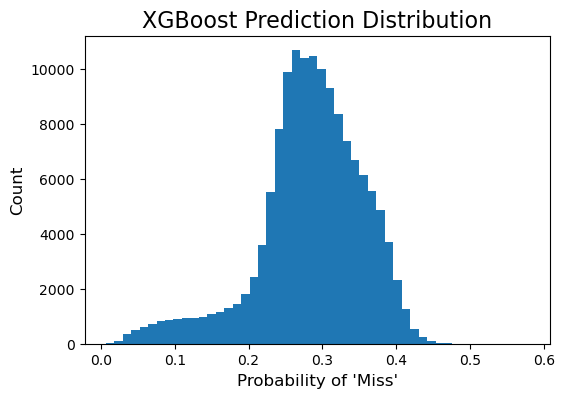

In [13]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_xgb['test_pred'], bins=50)
ax.set_title('XGBoost Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [14]:
import torch.nn as nn
from torch import optim, Tensor, sigmoid
from torch.utils.data import DataLoader


In [15]:
# Define hyperparameters
learning_rate = 1e-4
batch_size = 1024
n_epochs = 100
loss_fn = nn.BCEWithLogitsLoss()


Took 0:12:21.522230 to train the neural network
Trivial logloss for this problem: 0.597
Training logloss on the NN model: 0.586
Test logloss on the NN model: 0.588
Test accuracy on the NN model: 71.54%


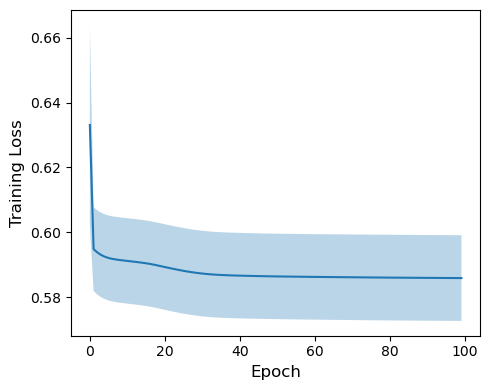

In [16]:
# Neural Network
d_nn = {'name': 'Neural Network',
        'model': RegressionNN(X_train.shape[-1], 16, 1).to('cpu').float()}

t_start = time()

# Define the training and test data loaders
train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
# optimizer = optim.SGD(d_nn['model'].parameters(), lr=learning_rate)
optimizer = optim.Adam(d_nn['model'].parameters(), lr=learning_rate)

# Train the model
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros(n_epochs)
t_start = time()
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader, d_nn['model'], loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Test the model
d_nn['train_pred'] = sigmoid(d_nn['model'](Tensor(X_train.astype(float)))).detach().numpy().squeeze()
d_nn['train_loss'] = log_loss(y_train, d_nn['train_pred'], eps=1e-7)
d_nn['test_pred'] = sigmoid(d_nn['model'](Tensor(X_test.astype(float)))).detach().numpy().squeeze()
d_nn['test_loss'] = log_loss(y_test, d_nn['test_pred'], eps=1e-7)
pred_classes = np.round(d_nn['test_pred'], 0)
d_nn['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the neural network')

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
fig.tight_layout()

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NN model: {d_nn['train_loss']:4.3f}")
print(f"Test logloss on the NN model: {d_nn['test_loss']:4.3f}")
print(f"Test accuracy on the NN model: {d_nn['test_acc']:4.2f}%")


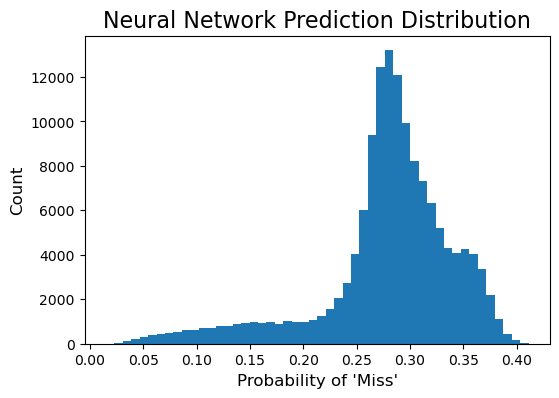

In [17]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn['test_pred'], bins=50)
ax.set_title('Neural Network Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [18]:
# List of all model classes
model_list = [d_logr, d_nbayes, d_xgb, d_nn]
n_models = len(model_list)
model_names = [model['name'] for model in model_list]


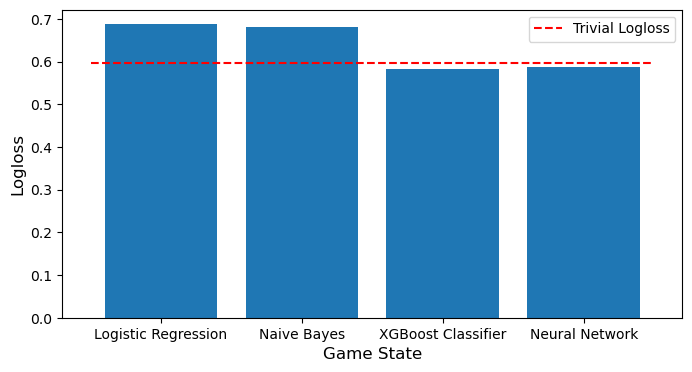

In [19]:
# Compare the model performances by logloss
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
width = 0.8
xs = np.arange(len(model_list)) + 0.5
# train_loss = [model['train_loss'] for model in models]
test_loss = [model['test_loss'] for model in model_list]
ax.bar(xs, test_loss, width=width)
ax.plot([0, len(model_list)], [dumb_loss, dumb_loss], 'r--', label='Trivial Logloss')
ax.set_xlabel('Game State', fontsize=12)
ax.set_xticks(xs)
ax.set_xticklabels(model_names, fontsize=10)
ax.set_ylabel('Logloss', fontsize=12)
# ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));
ax.legend(loc=1);


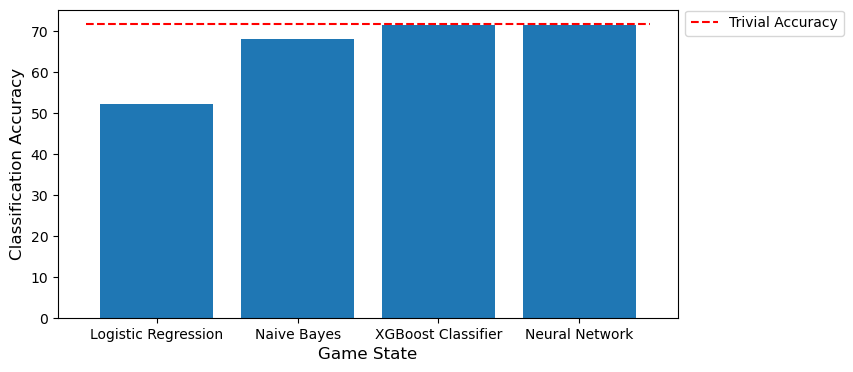

In [20]:
# Compare the model performances by logloss
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
test_acc = [model['test_acc'] for model in model_list]
f_class = 100 * (1 - p_miss)
ax.bar(xs, test_acc, width=width)
ax.plot([0, len(model_list)], [f_class, f_class], 'r--', label='Trivial Accuracy')
ax.set_xlabel('Game State', fontsize=12)
ax.set_xticks(xs)
ax.set_xticklabels(model_names, fontsize=10)
ax.set_ylabel('Classification Accuracy', fontsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/marshineer/Hockey-Analytics/models/common_plot.py:66: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


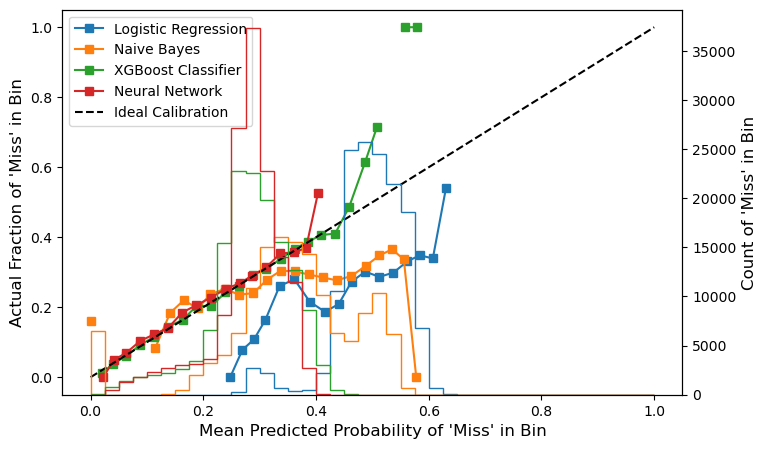

In [21]:
# Neural network calibration curves
test_preds = [model['test_pred'] for model in model_list]
test_ys = [y_test] * len(model_list)
mpl_objs = plot_calibration_curves(test_preds, test_ys, names=model_names,
                                   n_bins=40, avg_curve=False, class1='Miss')


# Calibrated Models



In [22]:
# Logistic regression model calibration
t_start = time()
calibrate_obj = CalibratedClassifierCV(d_logr['model'], method='isotonic', cv='prefit', n_jobs=-1)
calibrate_obj.fit(X_valid, y_valid)
d_logr['calibrated_model'] = calibrate_obj

# Make calibrated predictions on the test set
d_logr['test_pred_cal'] = d_logr['calibrated_model'].predict_proba(X_test)[:, 1]
d_logr['test_loss_cal'] = log_loss(y_test, d_logr['test_pred_cal'])
valid_classes = np.round(d_logr['test_pred_cal'], 0)
d_logr['test_acc_cal'] = 100 * (valid_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to calibrate the logistic regression model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Test logloss on the Logit model: {d_logr['test_loss_cal']:4.3f}")
print(f"Test accuracy on the Logit model: {d_logr['test_acc_cal']:4.2f}%")


Took 0:00:00.201523 to calibrate the logistic regression model
Trivial logloss for this problem: 0.597
Test logloss on the Logit model: 0.592
Test accuracy on the Logit model: 71.55%


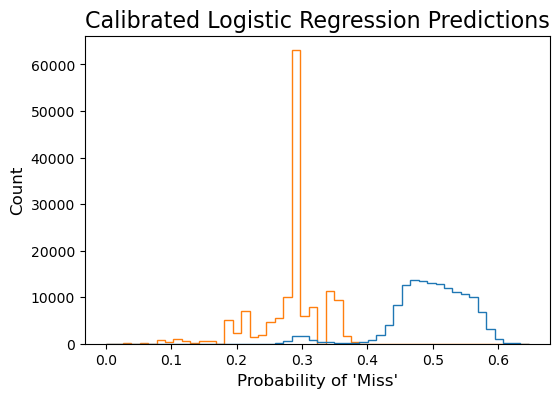

In [23]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist([d_logr['test_pred'], d_logr['test_pred_cal']], histtype='step', bins=50)
ax.set_title('Calibrated Logistic Regression Predictions', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [24]:
# Naive Bayes model calibration
t_start = time()
calibrate_obj = CalibratedClassifierCV(d_nbayes['model'], method='isotonic', cv='prefit', n_jobs=-1)
calibrate_obj.fit(X_valid, y_valid)
d_nbayes['calibrated_model'] = calibrate_obj

# Make calibrated predictions on the test set
d_nbayes['test_pred_cal'] = d_nbayes['calibrated_model'].predict_proba(X_test)[:, 1]
d_nbayes['test_loss_cal'] = log_loss(y_test, d_nbayes['test_pred_cal'])
valid_classes = np.round(d_nbayes['test_pred_cal'], 0)
d_nbayes['test_acc_cal'] = 100 * (valid_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to calibrate the naive bayes model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Test logloss on the NB model: {d_nbayes['test_loss_cal']:4.3f}")
print(f"Test accuracy on the NB model: {d_nbayes['test_acc_cal']:4.2f}%")


Took 0:00:00.262084 to calibrate the naive bayes model
Trivial logloss for this problem: 0.597
Test logloss on the NB model: 0.592
Test accuracy on the NB model: 71.54%


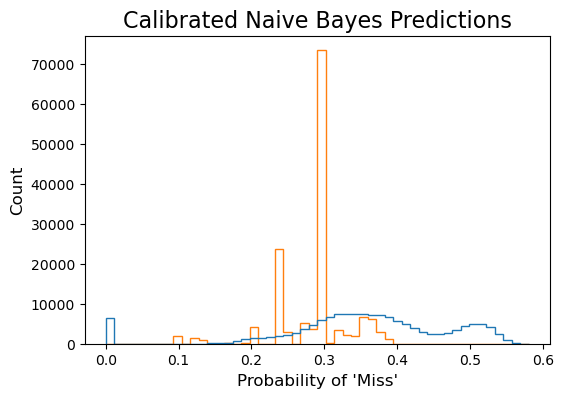

In [25]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist([d_nbayes['test_pred'], d_nbayes['test_pred_cal']], histtype='step', bins=50)
ax.set_title('Calibrated Naive Bayes Predictions', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [26]:
# XGBoost model calibration
t_start = time()
calibrate_obj = CalibratedClassifierCV(d_xgb['model'], method='isotonic', cv='prefit', n_jobs=-1)
calibrate_obj.fit(X_valid, y_valid)
d_xgb['calibrated_model'] = calibrate_obj

# Make calibrated predictions on the test set
d_xgb['test_pred_cal'] = d_xgb['calibrated_model'].predict_proba(X_test)[:, 1]
d_xgb['test_loss_cal'] = log_loss(y_test, d_xgb['test_pred_cal'])
valid_classes = np.round(d_xgb['test_pred_cal'], 0)
d_xgb['test_acc_cal'] = 100 * (valid_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to calibrate the XGBoost model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Test logloss on the XGB model: {d_xgb['test_loss_cal']:4.3f}")
print(f"Test accuracy on the XGB model: {d_xgb['test_acc_cal']:4.2f}%")


Took 0:00:00.334386 to calibrate the XGBoost model
Trivial logloss for this problem: 0.597
Test logloss on the XGB model: 0.583
Test accuracy on the XGB model: 71.55%


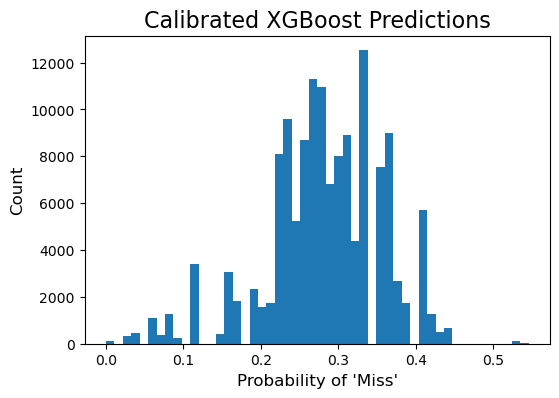

In [27]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_xgb['test_pred_cal'], bins=50)
ax.set_title('Calibrated XGBoost Predictions', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


In [28]:
# Neural network model calibration
t_start = time()
calibrate_obj = IsotonicRegression(y_min=0, y_max=1, increasing='auto', out_of_bounds='clip')
d_nn['valid_pred'] = sigmoid(d_nn['model'](Tensor(X_valid.astype(float)))).detach().numpy().squeeze()

# Make calibrated predictions on the test set
calibrate_obj.fit(d_nn['valid_pred'], y_valid)
d_nn['test_pred_cal'] = calibrate_obj.predict(d_nn['test_pred'])
d_nn['test_loss_cal'] = log_loss(y_test, d_nn['test_pred_cal'])
valid_classes = np.round(d_nn['test_pred_cal'], 0)
d_nn['test_acc_cal'] = 100 * (valid_classes == y_test).sum() / y_test.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to calibrate the neural network model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Test logloss on the NN model: {d_nn['test_loss_cal']:4.3f}")
print(f"Test accuracy on the NN model: {d_nn['test_acc_cal']:4.2f}%")


Took 0:00:00.185828 to calibrate the neural network model
Trivial logloss for this problem: 0.597
Test logloss on the NN model: 0.588
Test accuracy on the NN model: 71.54%


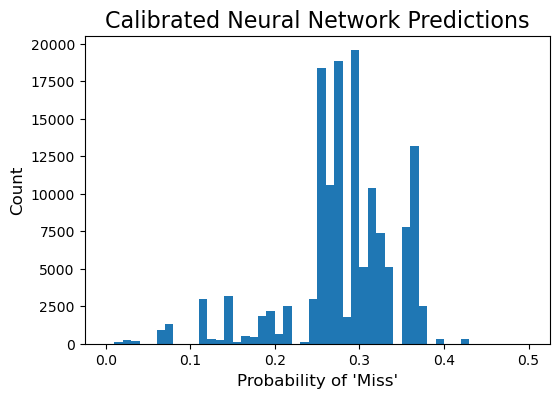

In [29]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn['test_pred_cal'], bins=50)
ax.set_title('Calibrated Neural Network Predictions', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/marshineer/Hockey-Analytics/models/common_plot.py:66: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


[  156  1707  2545 14258 23772 84481 15087     0     1    11]
[    1    19  2602  1635   281 26761  8384 77849  7684 16802]
[  895  3006  6867  7449 42915 39086 31728  9267   686   119]
[  526  2250  6745  5115  6227 69115 27942 23773   324     1]


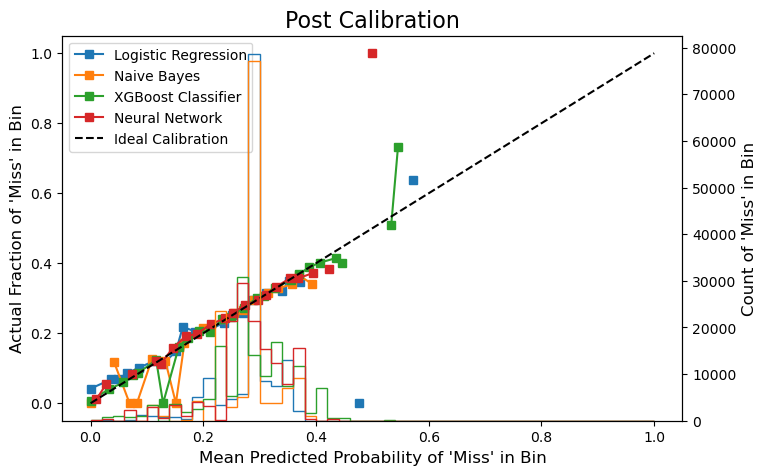

In [30]:
# Neural network calibration curves
test_preds = [model['test_pred_cal'] for model in model_list]
test_ys = [y_test] * len(model_list)
mpl_objs = plot_calibration_curves(test_preds, test_ys, names=model_names,
                                   n_bins=50, avg_curve=False, class1='Miss',
                                   plt_ttl='Post Calibration')
for yhats in test_preds:
    counts, _ = np.histogram(yhats)
    print(counts)


# Feature Importance and Reduction

Choose XGBoost because it trains faster and is already an ensemble method
Only a few features seem to matter (mutual information seems to give untrustworthy results)

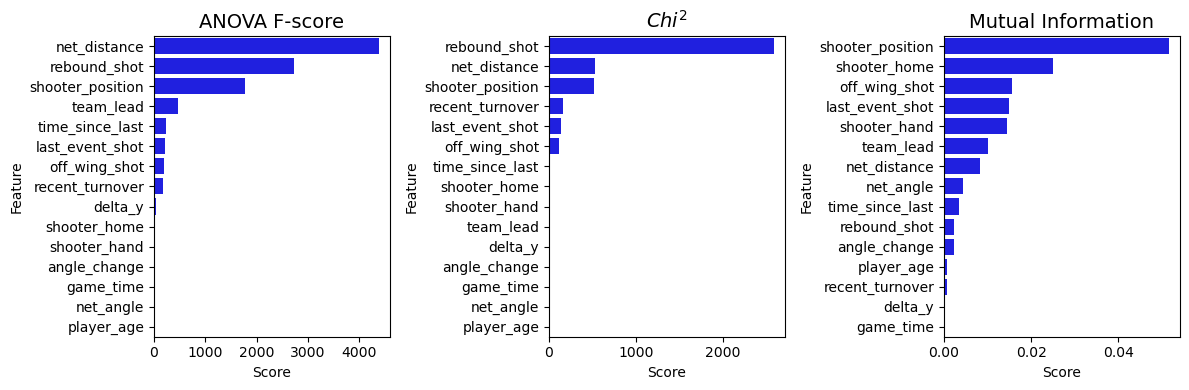

In [31]:
# Score the features using cross-correlation-based f-scoring
score_methods = [f_classif, chi2, mutual_info_classif]
score_names = ['ANOVA F-score', r'$Chi^2$', 'Mutual Information']
fig, axes = plt.subplots(1, len(score_methods), figsize=(12, 4))
for i, (method, name) in enumerate(zip(score_methods, score_names)):
    feature_eval = SelectKBest(score_func=method, k='all')
    fit = feature_eval.fit(X_train, y_train)
    best_scores = pd.DataFrame(fit.scores_)
    feat_list = pd.DataFrame(data_df.columns[:-1])

    select_feats = pd.concat([feat_list, best_scores], axis=1)
    select_feats.columns = ['Feature', 'Score']
    sorted_scores = select_feats.sort_values(['Score'])
    sorted_feats = sorted_scores['Feature'][:-1]
    
    sns.barplot(x="Score", y="Feature", data=sorted_scores[::-1], color="b", ax=axes[i])
    axes[i].set_title(score_names[i], fontsize=14)
fig.tight_layout();


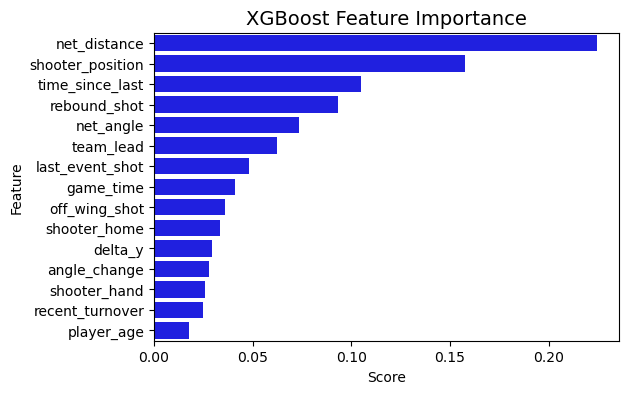

In [32]:
# Get feature importances from trained XGBoost model
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
best_scores = pd.DataFrame(d_xgb['model'].feature_importances_)
feat_list = pd.DataFrame(data_df.columns[:-1])

select_feats = pd.concat([feat_list, best_scores], axis=1)
select_feats.columns = ['Feature', 'Score']
sorted_scores = select_feats.sort_values(['Score'])
sorted_feats = sorted_scores['Feature'][:-1]

sns.barplot(x="Score", y="Feature", data=sorted_scores[::-1], color="b", ax=ax)
ax.set_title('XGBoost Feature Importance', fontsize=14);


In [55]:
# Reduce the number of features to a subset
# feature_subset = ['net_distance', 'shooter_position', 'rebound_shot',
#                   'off_wing_shot', 'last_event_turnover', 'missed']
feature_subset = ['net_distance', 'net_angle', 'time_since_last', 'game_time',
                  'rebound_shot', 'shooter_position', 'off_wing_shot', 'missed']
data_df_sub = data_df[feature_subset]

# Split the data into stratified training and test sets
X_pd, y_pd = data_df_sub.iloc[:, :-1].values, data_df_sub.iloc[:, -1].values
tmp_split = train_test_split(X_pd, y_pd, test_size=0.3, random_state=66,
                             stratify=y_pd)
X_train_sub, X_temp, y_train_sub, y_temp = tmp_split
tmp_split = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
X_valid_sub, X_test_sub, y_valid_sub, y_test_sub = tmp_split

# Scale the data
x_scaler_sub = MinMaxScaler()
X_train_norm = x_scaler.fit_transform(X_train_sub[:, 4].reshape(-1, 1))
X_train_sub[:, 4] = X_train_norm.squeeze()
X_valid_norm = x_scaler.transform(X_valid_sub[:, 4].reshape(-1, 1))
X_valid_sub[:, 4] = X_valid_norm.squeeze()
X_test_norm = x_scaler.transform(X_test_sub[:, 4].reshape(-1, 1))
X_test_sub[:, 4] = X_test_norm.squeeze()
    

In [56]:
# XGBoost model
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
d_xgb_sub = {'name': 'XGBoost Classifier Reduced',
             'model': XGBClassifier(use_label_encoder=False, tree_method='hist'),
             'n_itr': 50,
             'params': {'n_estimators': [100, 200, 400, 800],
                        'learning_rate': np.linspace(0.1, 0.9, 9),
                        'subsample': np.linspace(0.4, 1., 7),
                        'min_child_weight': [1, 5, 10, 20],
                        'max_leaves': [10, 20, 40, 80],
                        'max_depth': np.arange(2, 10),
                        'gamma': [1, 2, 4, 8]}}

# Train the models using k-fold cross-validation and a random parameter search
t_start = time()
# param_search = GridSearchCV(model['model'], model['params'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search = RandomizedSearchCV(d_xgb_sub['model'], d_xgb_sub['params'], n_iter=d_xgb_sub['n_itr'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train_sub, y_train_sub)
d_xgb_sub['search_result'] = param_search
d_xgb_sub['model'] = param_search.best_estimator_
d_xgb_sub['train_loss'] = -param_search.best_score_

# Make predictions on the test set
d_xgb_sub['test_pred'] = d_xgb_sub['model'].predict_proba(X_test_sub)[:, 1]
d_xgb_sub['test_loss'] = log_loss(y_test_sub, d_xgb_sub['test_pred'])
pred_classes = np.round(d_xgb_sub['test_pred'], 0)
d_xgb_sub['test_acc'] = 100 * (pred_classes == y_test_sub).sum() / y_test_sub.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the xgboost model')

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the XGB model: {d_xgb_sub['train_loss']:4.3f}")
print(f"Test logloss on the XGB model: {d_xgb_sub['test_loss']:4.3f}")
print(f"Test accuracy on the XGB model: {d_xgb_sub['test_acc']:4.2f}%")


Took 0:35:40.999299 to train the xgboost model
Trivial logloss for this problem: 0.597
Training logloss on the XGB model: 0.584
Test logloss on the XGB model: 0.585
Test accuracy on the XGB model: 71.55%


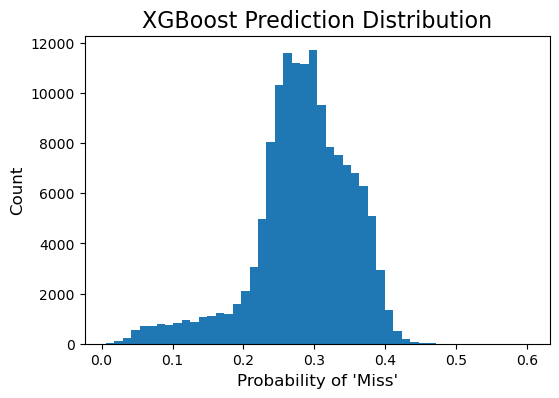

In [57]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_xgb_sub['test_pred'], bins=50)
ax.set_title('XGBoost Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


Took 0:11:49.312384 to train the neural network
Trivial logloss for this problem: 0.597
Training logloss on the NN model: 0.586
Test logloss on the NN model: 0.588
Test accuracy on the NN model: 71.54%


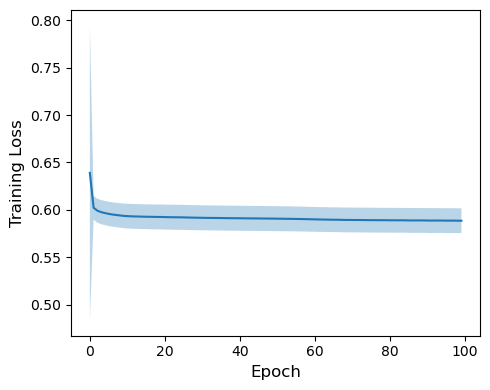

In [58]:
# Neural Network
d_nn_sub = {'name': 'Neural Network Reduced',
            'model': RegressionNN(X_train_sub.shape[-1], 16, 1).to('cpu').float()}

# Define the training and test data loaders
train_data = CustomDataset(X_train_sub, y_train_sub)
test_data = CustomDataset(X_test_sub, y_test_sub)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
# optimizer = optim.SGD(d_nn_sub['model'].parameters(), lr=learning_rate)
optimizer = optim.Adam(d_nn_sub['model'].parameters(), lr=learning_rate)

# Train the model
t_start = time()
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros(n_epochs)
t_start = time()
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader, d_nn_sub['model'], loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Test the model
d_nn_sub['train_pred'] = sigmoid(d_nn_sub['model'](Tensor(X_train_sub.astype(float)))).detach().numpy().squeeze()
d_nn_sub['train_loss'] = log_loss(y_train_sub, d_nn_sub['train_pred'], eps=1e-7)
d_nn_sub['test_pred'] = sigmoid(d_nn_sub['model'](Tensor(X_test_sub.astype(float)))).detach().numpy().squeeze()
d_nn_sub['test_loss'] = log_loss(y_test_sub, d_nn_sub['test_pred'], eps=1e-7)
pred_classes = np.round(d_nn_sub['test_pred'], 0)
d_nn_sub['test_acc'] = 100 * (pred_classes == y_test_sub).sum() / y_test_sub.size

t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the neural network')

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
fig.tight_layout()

print(f"Trivial logloss for this problem: {dumb_loss:4.3f}")
print(f"Training logloss on the NN model: {d_nn['train_loss']:4.3f}")
print(f"Test logloss on the NN model: {d_nn['test_loss']:4.3f}")
print(f"Test accuracy on the NN model: {d_nn['test_acc']:4.2f}%")


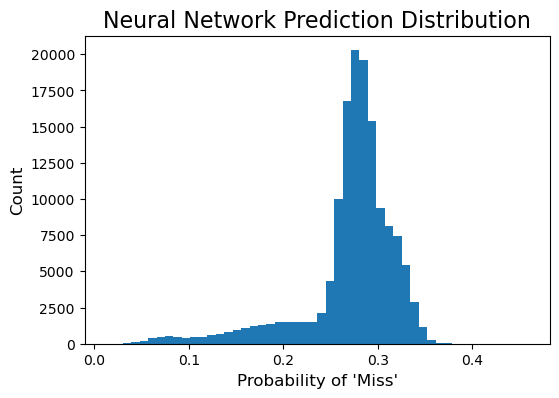

In [59]:
# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn_sub['test_pred'], bins=50)
ax.set_title('Neural Network Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Miss'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/marshineer/Hockey-Analytics/models/common_plot.py:66: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size


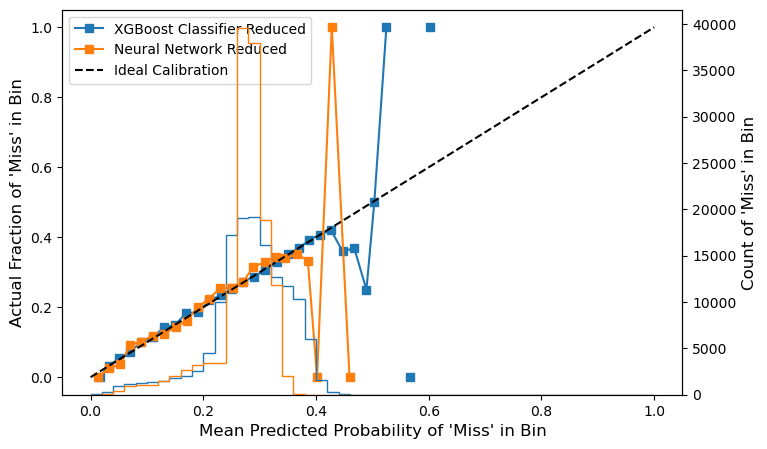

In [60]:
# Neural network calibration curves
subset_models = [d_xgb_sub, d_nn_sub]
test_preds = [model['test_pred'] for model in subset_models]
subset_names = [model['name'] for model in subset_models]
test_ys = [y_test] * len(subset_models)
mpl_objs = plot_calibration_curves(test_preds, test_ys, names=subset_names,
                                   n_bins=50, avg_curve=False, class1='Miss')


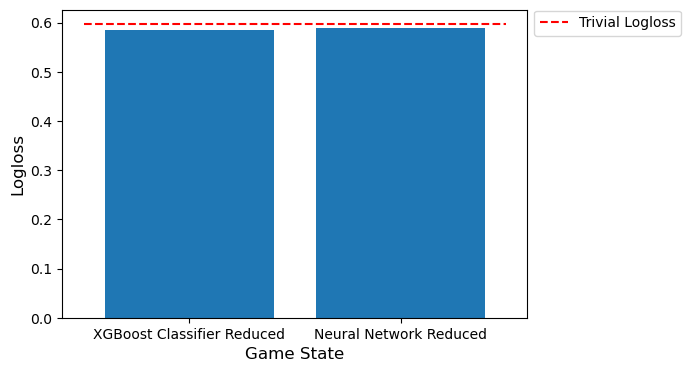

In [61]:
# Compare the model performances by logloss
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
width = 0.8
xs = np.arange(len(subset_models)) + 0.5
test_loss = [model['test_loss'] for model in subset_models]
ax.bar(xs, test_loss, width=width)
ax.plot([0, len(subset_models)], [dumb_loss, dumb_loss], 'r--', label='Trivial Logloss')
ax.set_xlabel('Game State', fontsize=12)
ax.set_xticks(xs)
ax.set_xticklabels(subset_names, fontsize=10)
ax.set_ylabel('Logloss', fontsize=12)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));
# ax.legend(loc=1);


In [62]:
# Determine hyperparameters
xgb_results = pd.DataFrame(d_xgb_sub['search_result'].cv_results_)
xgb_results.sort_values('rank_test_score', inplace=True)
xgb_results.reset_index(drop=True, inplace=True)
# print(xgb_results.columns.tolist())
result_cols = ['param_subsample', 'param_n_estimators',
               'param_min_child_weight', 'param_max_leaves',
               'param_max_depth', 'param_learning_rate',
               'param_gamma', 'params', 'mean_test_score',
               'std_test_score', 'rank_test_score']
xgb_results = xgb_results[result_cols]
new_result_cols = ['subsample', 'n_estimators', 'min_child_weight', 'max_leaves',
                   'max_depth', 'learning_rate', 'gamma', 'params',
                   'mean_test_score', 'std_test_score', 'rank_test_score']
xgb_results.columns = new_result_cols
# display(xgb_results)
print(f'The average cross-validation negative Logloss is '
      f'{np.mean(xgb_results.mean_test_score):4.3f} +/- '
      f'{np.std(xgb_results.mean_test_score):4.3f}')


The average cross-validation negative Logloss is -0.586 +/- 0.006


In [63]:
display(xgb_results)


,subsample,n_estimators,min_child_weight,max_leaves,max_depth,learning_rate,gamma,params,mean_test_score,std_test_score,rank_test_score
0,0.7,400,5,10,5,0.1,1,"{'subsample': 0.7, 'n_estimators': 400, 'min_c...",-0.583935,0.000482,1
1,1.0,100,1,40,5,0.1,2,"{'subsample': 1.0, 'n_estimators': 100, 'min_c...",-0.583946,0.000446,2
2,1.0,200,5,40,7,0.2,2,"{'subsample': 1.0, 'n_estimators': 200, 'min_c...",-0.583953,0.000469,3
3,0.9,200,1,20,9,0.2,2,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.583975,0.000489,4
4,0.9,200,10,20,4,0.4,4,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.584011,0.000458,5
5,0.8,800,20,20,8,0.4,8,"{'subsample': 0.8, 'n_estimators': 800, 'min_c...",-0.584012,0.000473,6
6,0.9,200,20,40,5,0.4,4,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.584024,0.000462,7
7,1.0,400,20,20,3,0.3,1,"{'subsample': 1.0, 'n_estimators': 400, 'min_c...",-0.584043,0.000431,8
8,0.9,200,1,80,9,0.1,2,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.584055,0.000535,9
9,0.9,800,20,40,3,0.5,4,"{'subsample': 0.8999999999999999, 'n_estimator...",-0.584060,0.000418,10
